In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression
import statsmodels.api as sm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")
print("📊 Ready for Multiple Linear Regression Analysis")


✅ Libraries imported successfully!
📊 Ready for Multiple Linear Regression Analysis


In [3]:

# Load the dataset
df = pd.read_csv('../Datasets/Cleaned_Preprocessed/mgnrega_data_fully_cleaned.csv')

print("📋 Dataset Information:")
print(f"Shape: {df.shape}")
print(f"Columns: {len(df.columns)}")

# Select relevant numerical features for multiple regression
feature_columns = [
    'Total_No_of_Workers', 'Total_Households_Worked', 'Total_Individuals_Worked',
    'Average_Wage_rate_per_day_per_person', 'Wages', 'Persondays_of_Central_Liability_so_far',
    'SC_persondays', 'ST_persondays', 'Women_Persondays', 'Total_Adm_Expenditure',
    'Number_of_Completed_Works', 'Number_of_Ongoing_Works'
]

target_column = 'Total_Exp'

print(f"\n🎯 Selected Features ({len(feature_columns)}):")
for i, col in enumerate(feature_columns, 1):
    print(f"{i:2d}. {col}")

print(f"\n🎯 Target Variable: {target_column}")


📋 Dataset Information:
Shape: (302752, 36)
Columns: 36

🎯 Selected Features (12):
 1. Total_No_of_Workers
 2. Total_Households_Worked
 3. Total_Individuals_Worked
 4. Average_Wage_rate_per_day_per_person
 5. Wages
 6. Persondays_of_Central_Liability_so_far
 7. SC_persondays
 8. ST_persondays
 9. Women_Persondays
10. Total_Adm_Expenditure
11. Number_of_Completed_Works
12. Number_of_Ongoing_Works

🎯 Target Variable: Total_Exp


In [4]:

# Create feature matrix and target vector
X = df[feature_columns].copy()
y = df[target_column].copy()

print("🔍 Data Quality Check:")
print(f"Original dataset shape: {df.shape}")
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Check for missing values
missing_values = X.isnull().sum()
print(f"\n📊 Missing Values per Feature:")
for col, missing in missing_values.items():
    if missing > 0:
        print(f"  {col}: {missing} ({missing/len(X)*100:.1f}%)")

# Remove rows with missing values
df_clean = df[feature_columns + [target_column]].dropna()
X_clean = df_clean[feature_columns]
y_clean = df_clean[target_column]

print(f"\n🧹 After removing missing values:")
print(f"Clean dataset shape: {df_clean.shape}")
print(f"Removed {len(df) - len(df_clean)} rows")

🔍 Data Quality Check:
Original dataset shape: (302752, 36)
Feature matrix shape: (302752, 12)
Target vector shape: (302752,)

📊 Missing Values per Feature:

🧹 After removing missing values:
Clean dataset shape: (302752, 13)
Removed 0 rows


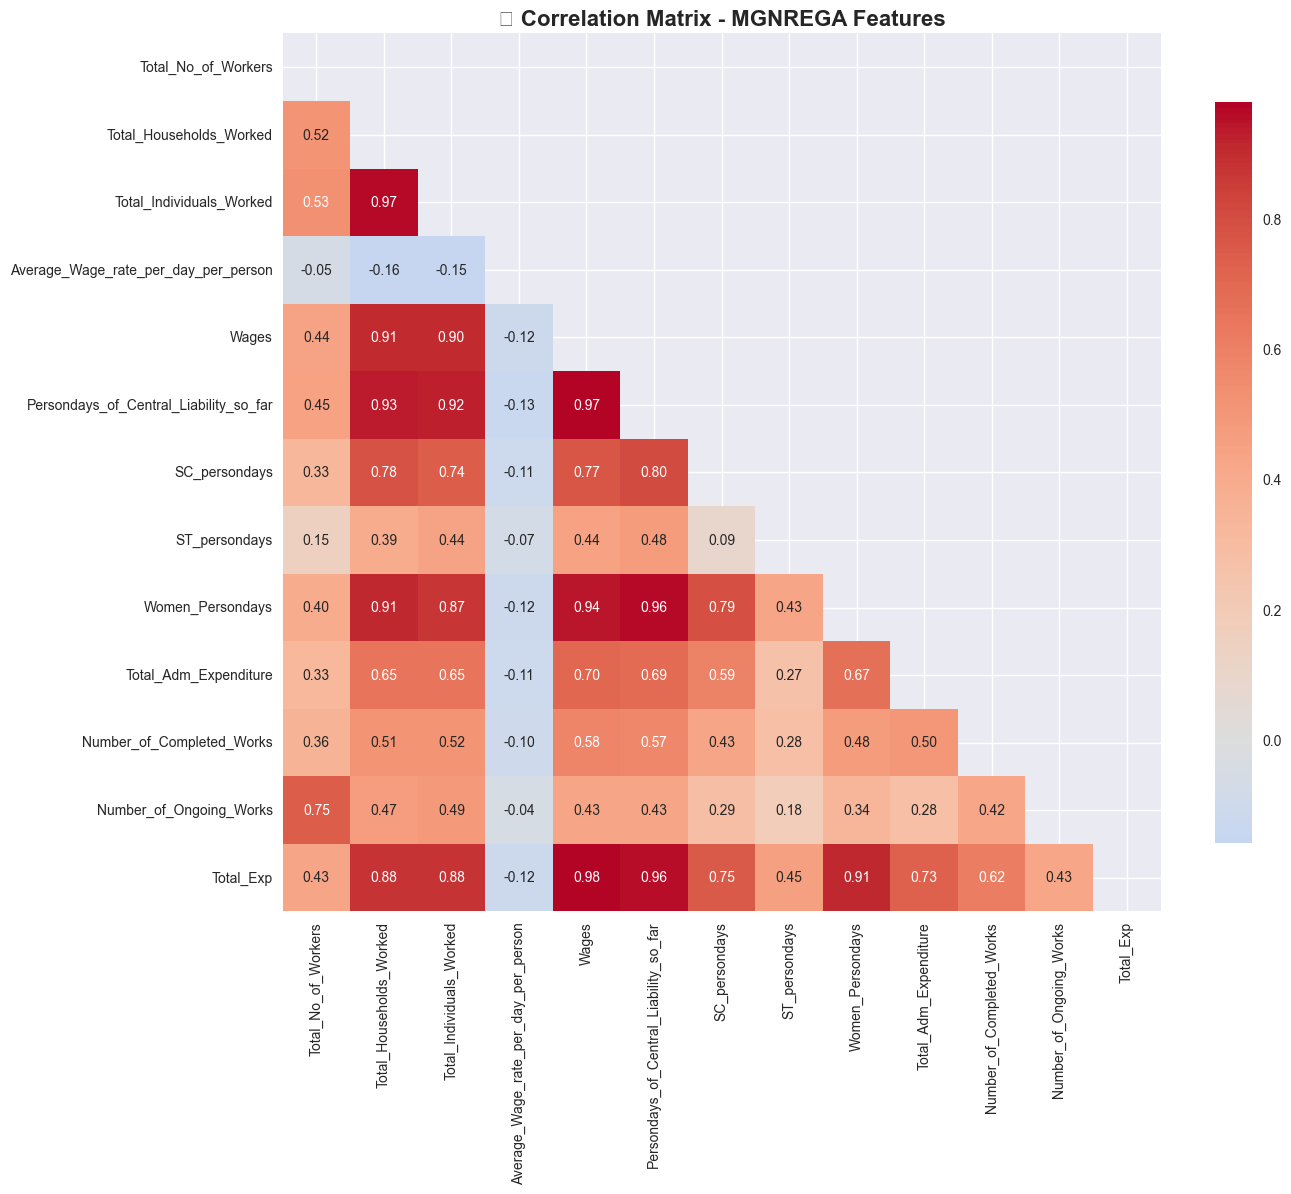


🎯 Correlation with Total_Exp:
  Wages: 0.9782
  Persondays_of_Central_Liability_so_far: 0.9559
  Women_Persondays: 0.9146
  Total_Households_Worked: 0.8846
  Total_Individuals_Worked: 0.8802
  SC_persondays: 0.7545
  Total_Adm_Expenditure: 0.7332
  Number_of_Completed_Works: 0.6183
  ST_persondays: 0.4518
  Total_No_of_Workers: 0.4292
  Number_of_Ongoing_Works: 0.4254
  Average_Wage_rate_per_day_per_person: -0.1161


In [5]:

# Calculate correlation matrix
correlation_matrix = df_clean.corr()

# Create correlation heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            cmap='coolwarm', 
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={'shrink': 0.8})
plt.title('📊 Correlation Matrix - MGNREGA Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Analyze correlation with target variable
target_correlations = correlation_matrix[target_column].sort_values(ascending=False)
print(f"\n🎯 Correlation with {target_column}:")
for feature, corr in target_correlations.items():
    if feature != target_column:
        print(f"  {feature}: {corr:.4f}")


In [6]:

# Calculate VIF (Variance Inflation Factor) for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    return vif_data

vif_df = calculate_vif(X_clean)
print("📊 Variance Inflation Factor (VIF) Analysis:")
print("="*50)
print(vif_df.sort_values('VIF', ascending=False))

# Remove features with high VIF (>10)
high_vif_features = vif_df[vif_df['VIF'] > 10]['Feature'].tolist()
print(f"\n🚨 Features with VIF > 10 (indicating multicollinearity):")
for feature in high_vif_features:
    print(f"  • {feature}")

# Select features with reasonable VIF
selected_features = vif_df[vif_df['VIF'] <= 10]['Feature'].tolist()
X_selected = X_clean[selected_features]

print(f"\n✅ Selected features after VIF filtering ({len(selected_features)}):")
for i, feature in enumerate(selected_features, 1):
    print(f"{i:2d}. {feature}")

📊 Variance Inflation Factor (VIF) Analysis:
                                   Feature        VIF
5   Persondays_of_Central_Liability_so_far  71.525591
1                  Total_Households_Worked  41.332665
2                 Total_Individuals_Worked  38.051675
4                                    Wages  33.511311
8                         Women_Persondays  27.143898
6                            SC_persondays   5.659560
0                      Total_No_of_Workers   5.341730
11                 Number_of_Ongoing_Works   4.950618
9                    Total_Adm_Expenditure   3.050135
10               Number_of_Completed_Works   2.535745
7                            ST_persondays   2.272638
3     Average_Wage_rate_per_day_per_person   1.162205

🚨 Features with VIF > 10 (indicating multicollinearity):
  • Total_Households_Worked
  • Total_Individuals_Worked
  • Wages
  • Persondays_of_Central_Liability_so_far
  • Women_Persondays

✅ Selected features after VIF filtering (7):
 1. Total_No_of_Wor

In [7]:

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_clean, test_size=0.2, random_state=42
)

print("🔄 Train-Test Split:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

# Feature scaling (important for multiple regression interpretation)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=selected_features, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=selected_features, index=X_test.index)

print("✅ Feature scaling completed")


🔄 Train-Test Split:
Training set: 242201 samples
Testing set: 60551 samples
✅ Feature scaling completed


In [8]:

# Create and train the model
mlr_model = LinearRegression()
mlr_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = mlr_model.predict(X_train_scaled)
y_test_pred = mlr_model.predict(X_test_scaled)

# Model coefficients
coefficients = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': mlr_model.coef_,
    'Abs_Coefficient': np.abs(mlr_model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print("🎯 Multiple Linear Regression Model (sklearn):")
print("="*60)
print(f"Intercept: {mlr_model.intercept_:.2f}")
print(f"\nFeature Coefficients (sorted by importance):")
for _, row in coefficients.iterrows():
    print(f"  {row['Feature']}: {row['Coefficient']:.6f}")


🎯 Multiple Linear Regression Model (sklearn):
Intercept: 6438.93

Feature Coefficients (sorted by importance):
  SC_persondays: 4135.238011
  Total_Adm_Expenditure: 2429.377690
  ST_persondays: 2388.026484
  Number_of_Completed_Works: 1433.012188
  Number_of_Ongoing_Works: 635.861604
  Total_No_of_Workers: 302.733227
  Average_Wage_rate_per_day_per_person: 42.704923


In [9]:

# Calculate evaluation metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("📊 Model Performance Metrics:")
print("="*50)
print(f"Training Set:")
print(f"  R² Score: {train_r2:.4f}")
print(f"  RMSE: {train_rmse:.2f}")
print(f"  MAE: {train_mae:.2f}")
print()
print(f"Testing Set:")
print(f"  R² Score: {test_r2:.4f}")
print(f"  RMSE: {test_rmse:.2f}")
print(f"  MAE: {test_mae:.2f}")

# Model interpretation
print(f"\n🔍 Model Interpretation:")
print(f"• The model explains {test_r2*100:.1f}% of variance in Total Expenditure")
print(f"• Adjusted R²: {1 - (1-test_r2)*(len(y_test)-1)/(len(y_test)-len(selected_features)-1):.4f}")


📊 Model Performance Metrics:
Training Set:
  R² Score: 0.8186
  RMSE: 3779.22
  MAE: 2048.50

Testing Set:
  R² Score: 0.8213
  RMSE: 3714.85
  MAE: 2015.86

🔍 Model Interpretation:
• The model explains 82.1% of variance in Total Expenditure
• Adjusted R²: 0.8213



📊 Statistical Analysis (Statsmodels):
                            OLS Regression Results                            
Dep. Variable:              Total_Exp   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                 1.561e+05
Date:                Mon, 06 Oct 2025   Prob (F-statistic):               0.00
Time:                        14:19:34   Log-Likelihood:            -2.3387e+06
No. Observations:              242201   AIC:                         4.678e+06
Df Residuals:                  242193   BIC:                         4.678e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

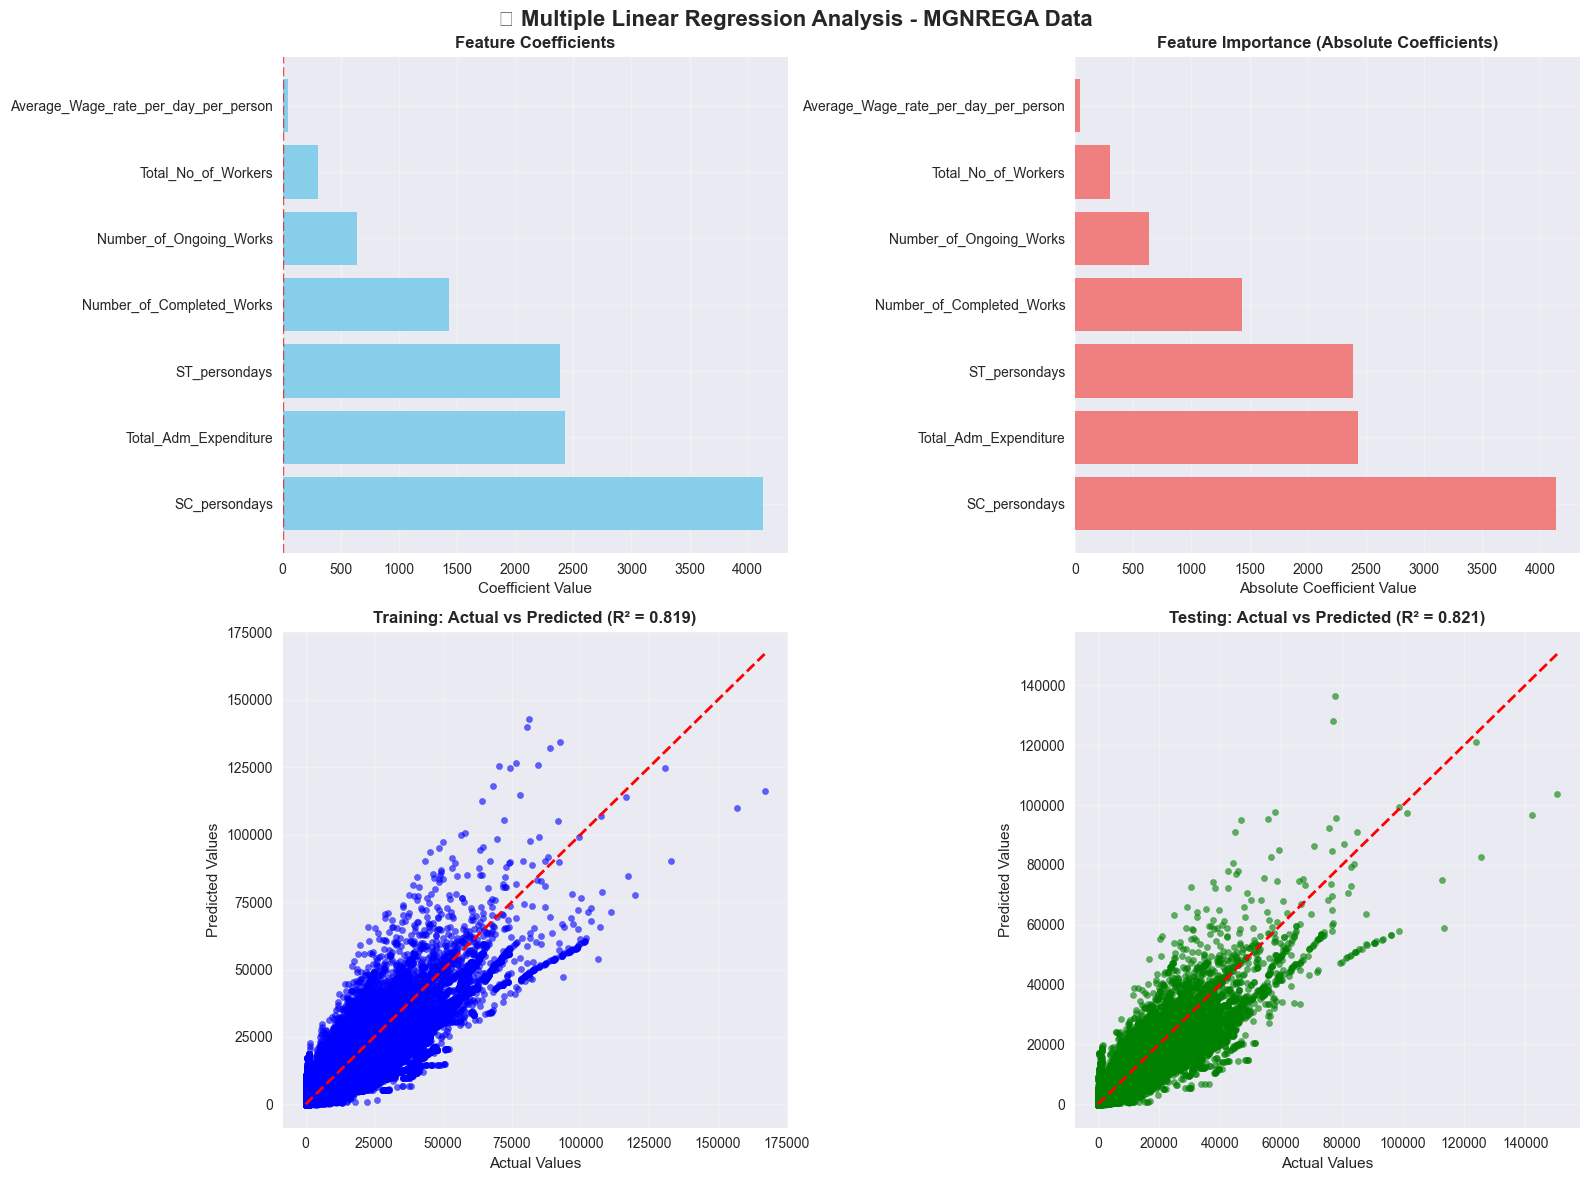

In [10]:

# Add constant for statsmodels (intercept)
X_train_sm = sm.add_constant(X_train_scaled_df)
X_test_sm = sm.add_constant(X_test_scaled_df)

# Fit OLS model
model_sm = sm.OLS(y_train, X_train_sm).fit()

print("\n📊 Statistical Analysis (Statsmodels):")
print("="*60)
print(model_sm.summary())

# Extract p-values for significance testing
p_values = model_sm.pvalues[1:]  # Exclude constant
significant_features = p_values[p_values < 0.05].index.tolist()

print(f"\n🎯 Statistically Significant Features (p < 0.05):")
for feature in significant_features:
    p_val = p_values[feature]
    print(f"  • {feature}: p = {p_val:.4f}")

# =============================================================================
# CELL 10: Feature Importance Visualization
# =============================================================================

# Create feature importance plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('📈 Multiple Linear Regression Analysis - MGNREGA Data', fontsize=16, fontweight='bold')

# 1. Feature Coefficients
axes[0, 0].barh(coefficients['Feature'], coefficients['Coefficient'], color='skyblue')
axes[0, 0].set_title('Feature Coefficients', fontweight='bold')
axes[0, 0].set_xlabel('Coefficient Value')
axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7)
axes[0, 0].grid(True, alpha=0.3)

# 2. Feature Importance (Absolute Coefficients)
axes[0, 1].barh(coefficients['Feature'], coefficients['Abs_Coefficient'], color='lightcoral')
axes[0, 1].set_title('Feature Importance (Absolute Coefficients)', fontweight='bold')
axes[0, 1].set_xlabel('Absolute Coefficient Value')
axes[0, 1].grid(True, alpha=0.3)

# 3. Actual vs Predicted (Training)
axes[1, 0].scatter(y_train, y_train_pred, alpha=0.6, color='blue', s=20)
axes[1, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', linewidth=2)
axes[1, 0].set_title(f'Training: Actual vs Predicted (R² = {train_r2:.3f})', fontweight='bold')
axes[1, 0].set_xlabel('Actual Values')
axes[1, 0].set_ylabel('Predicted Values')
axes[1, 0].grid(True, alpha=0.3)

# 4. Actual vs Predicted (Testing)
axes[1, 1].scatter(y_test, y_test_pred, alpha=0.6, color='green', s=20)
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
axes[1, 1].set_title(f'Testing: Actual vs Predicted (R² = {test_r2:.3f})', fontweight='bold')
axes[1, 1].set_xlabel('Actual Values')
axes[1, 1].set_ylabel('Predicted Values')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

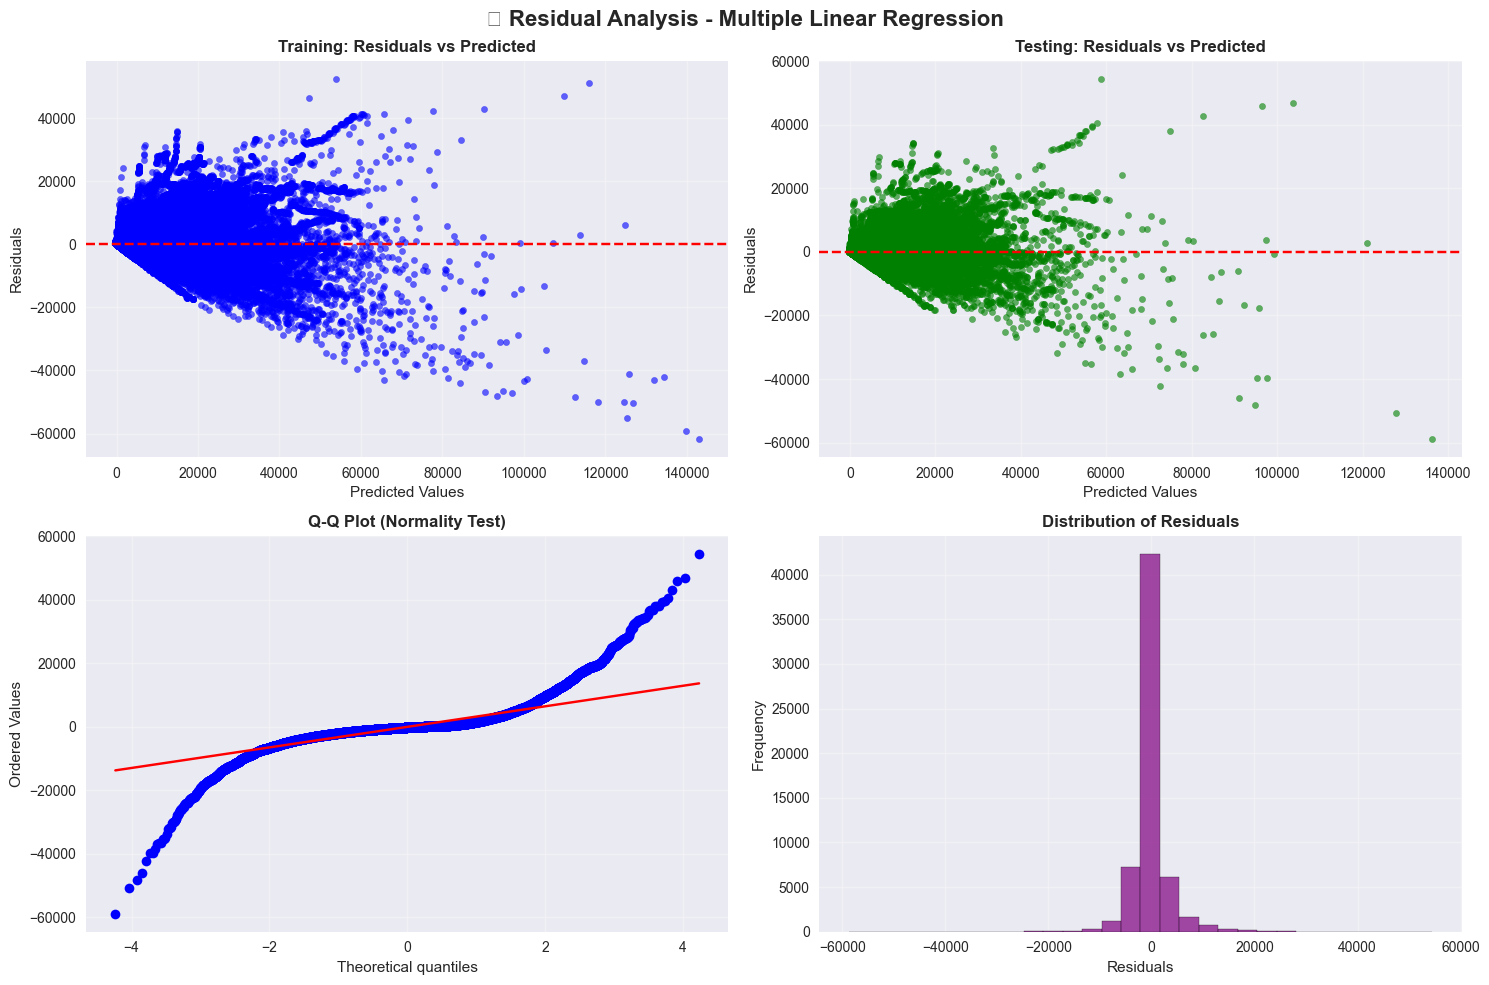

In [11]:

# Calculate residuals
residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred

# Create residual plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('📊 Residual Analysis - Multiple Linear Regression', fontsize=16, fontweight='bold')

# 1. Residuals vs Predicted (Training)
axes[0, 0].scatter(y_train_pred, residuals_train, alpha=0.6, color='blue', s=20)
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_title('Training: Residuals vs Predicted', fontweight='bold')
axes[0, 0].set_xlabel('Predicted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuals vs Predicted (Testing)
axes[0, 1].scatter(y_test_pred, residuals_test, alpha=0.6, color='green', s=20)
axes[0, 1].axhline(y=0, color='red', linestyle='--')
axes[0, 1].set_title('Testing: Residuals vs Predicted', fontweight='bold')
axes[0, 1].set_xlabel('Predicted Values')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Q Plot for normality
from scipy.stats import probplot
probplot(residuals_test, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normality Test)', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Histogram of residuals
axes[1, 1].hist(residuals_test, bins=30, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].set_title('Distribution of Residuals', fontweight='bold')
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:

# Make predictions for sample scenarios
sample_data = X_test_scaled_df.iloc[:5].copy()
sample_predictions = mlr_model.predict(sample_data)
sample_actual = y_test.iloc[:5]

print("🔮 Sample Predictions:")
print("="*60)
for i, (pred, actual) in enumerate(zip(sample_predictions, sample_actual)):
    error = abs(pred - actual)
    error_pct = (error / actual) * 100
    print(f"Sample {i+1}:")
    print(f"  Predicted: ₹{pred:,.2f}")
    print(f"  Actual:    ₹{actual:,.2f}")
    print(f"  Error:     ₹{error:,.2f} ({error_pct:.1f}%)")
    print()

# Feature importance ranking
print("📊 Feature Importance Ranking:")
print("="*40)
for i, (_, row) in enumerate(coefficients.iterrows(), 1):
    print(f"{i:2d}. {row['Feature']}: {row['Coefficient']:.6f}")

# =============================================================================
# CELL 13: Model Validation and Cross-Validation
# =============================================================================

from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(mlr_model, X_train_scaled, y_train, cv=5, scoring='r2')

print("\n🔄 Cross-Validation Results:")
print("="*40)
print(f"CV R² Scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Model stability
print(f"\n📊 Model Stability:")
print(f"• CV Score Range: {cv_scores.min():.4f} to {cv_scores.max():.4f}")
print(f"• CV Score Std: {cv_scores.std():.4f}")

if cv_scores.std() < 0.05:
    stability = "Very Stable"
elif cv_scores.std() < 0.1:
    stability = "Stable"
else:
    stability = "Less Stable"

print(f"• Model Stability: {stability}")

🔮 Sample Predictions:
Sample 1:
  Predicted: ₹-21.59
  Actual:    ₹208.07
  Error:     ₹229.67 (110.4%)

Sample 2:
  Predicted: ₹2,590.73
  Actual:    ₹2,278.60
  Error:     ₹312.13 (13.7%)

Sample 3:
  Predicted: ₹4,459.85
  Actual:    ₹3,347.60
  Error:     ₹1,112.24 (33.2%)

Sample 4:
  Predicted: ₹3,441.79
  Actual:    ₹2,528.27
  Error:     ₹913.52 (36.1%)

Sample 5:
  Predicted: ₹3,012.31
  Actual:    ₹2,448.52
  Error:     ₹563.79 (23.0%)

📊 Feature Importance Ranking:
 1. SC_persondays: 4135.238011
 2. Total_Adm_Expenditure: 2429.377690
 3. ST_persondays: 2388.026484
 4. Number_of_Completed_Works: 1433.012188
 5. Number_of_Ongoing_Works: 635.861604
 6. Total_No_of_Workers: 302.733227
 7. Average_Wage_rate_per_day_per_person: 42.704923

🔄 Cross-Validation Results:
CV R² Scores: [0.82186714 0.81727454 0.82168433 0.81510852 0.8165537 ]
Mean CV R²: 0.8185 (+/- 0.0055)

📊 Model Stability:
• CV Score Range: 0.8151 to 0.8219
• CV Score Std: 0.0028
• Model Stability: Very Stable


In [13]:

print("\n💡 Business Insights and Recommendations:")
print("="*60)

# Top contributing factors
top_features = coefficients.head(5)
print(f"🎯 Top 5 Contributing Factors to Total Expenditure:")
for i, (_, row) in enumerate(top_features.iterrows(), 1):
    direction = "increases" if row['Coefficient'] > 0 else "decreases"
    print(f"  {i}. {row['Feature']}: {direction} expenditure")

# Cost efficiency analysis
avg_features = X_selected.mean()
total_impact = sum(abs(mlr_model.coef_[i] * avg_features.iloc[i]) for i in range(len(selected_features)))

print(f"\n📈 Key Insights:")
print(f"• Model explains {test_r2*100:.1f}% of expenditure variation")
print(f"• {len(significant_features)} features are statistically significant")
print(f"• Average prediction error: ₹{test_mae:,.2f}")

print(f"\n🎯 Recommendations:")
print(f"• Focus on top contributing factors for budget planning")
print(f"• Monitor multicollinearity in feature selection")
print(f"• Use model for expenditure forecasting and resource allocation")

print(f"\n⚠️ Model Limitations:")
print(f"• Assumes linear relationships between features and target")
print(f"• May not capture complex interactions")
print(f"• Requires feature scaling for interpretation")

print("\n✅ Multiple Linear Regression Analysis Complete!")
print("="*60)


💡 Business Insights and Recommendations:
🎯 Top 5 Contributing Factors to Total Expenditure:
  1. SC_persondays: increases expenditure
  2. Total_Adm_Expenditure: increases expenditure
  3. ST_persondays: increases expenditure
  4. Number_of_Completed_Works: increases expenditure
  5. Number_of_Ongoing_Works: increases expenditure

📈 Key Insights:
• Model explains 82.1% of expenditure variation
• 7 features are statistically significant
• Average prediction error: ₹2,015.86

🎯 Recommendations:
• Focus on top contributing factors for budget planning
• Monitor multicollinearity in feature selection
• Use model for expenditure forecasting and resource allocation

⚠️ Model Limitations:
• Assumes linear relationships between features and target
• May not capture complex interactions
• Requires feature scaling for interpretation

✅ Multiple Linear Regression Analysis Complete!
